In [194]:
import random as rn
import pickle
from datetime import datetime
import pandas as pd
from hs_gimme.db_facade.db_facade_factory import get_mongo_client_db
from hs_tree_blenders_creation.batch_runners.data_sets import get_account_test_set, get_account_train_set
from hs_gimme.application_status_history_classifier.machine_learning_status_classifier import \
    get_machine_learning_status_classifier
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb
from datetime import timedelta
import copy
from collections import Counter
from sklearn.linear_model import LogisticRegression

In [2]:
ENV = 'production'
ACCOUNT = 'dallas'

In [3]:
mongo = gmcdb(ENV, ACCOUNT)

2024-03-04T14:34:31.927992Z [info     ] Mongos instances selected      environment=local file_path=/Users/dima/hiredscore/gimme/hs_gimme/db_facade/connection_string_builder.py function_name=get_selected_mongos_instances hostname=Dima-Shulga-MacBook-Pro hosts=['applicativedb-prod-mongos-3.omcomcom.com', 'applicativedb-prod-mongos-0.omcomcom.com'] line_number=38 module=hs_gimme.db_facade.connection_string_builder pid=42786


In [4]:
req_fields =  ['job_department',
              'country',
               'external_job_band',
               'external_recruiters',
               'top_category',
               'sub_category',
               'job_education',
               'seniority_level',
               'min_years_of_relevant_experience',
               'max_years_of_relevant_experience',
               'max_salary',
               'job_type',
               'is_visa_required',
               'is_remote_location', 
               'external_status',
               'industry',
               'open_date',
               'past_candidates_distribution_date',
               'is_recent_grad', 
               'is_intern',
               '_created_at',
               'date_posted',
               'job_create_date',
               'last_edit_date',
               'status_history',
               'recruiter_roles',
               'recruiting_type']

In [5]:
reference_date = datetime(2023, 11, 1)

In [6]:
reqs = list(mongo.req.find({'_created_at': {'$gt': reference_date}, 'date_posted': 
                            {'$gt': reference_date}, 'external_status': 'Filled'
                           }, req_fields))
len(reqs)

136

In [7]:
req_ids = [r['_id'] for r in reqs]

In [8]:
app_fields = ['req_id', 'ats_application', 'is_internal', 'grade_data.explainable_score_data']

In [9]:
apps = list(mongo.application.find({'req_id': {'$in': req_ids}}, app_fields))
len(apps)

2024-03-04T14:34:50.882281Z [warning  ] SlowLog                        command_name=getMore connection_id=applicativedb-prod-mongos-3.omcomcom.com:27017 duration_ms__numeric=10139.77 duration_threshold__numeric=10000 environment=local file_path=/Users/dima/hiredscore/gimme/hs_gimme/db_facade/slow_logs_utils.py function_name=write_slow_log hostname=Dima-Shulga-MacBook-Pro line_number=11 module=hs_gimme.db_facade.slow_logs_utils pid=42786 request_id=1264817709 source=PyMongo stack_snippet=
  File "/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_42786/3184223210.py", line 1, in <module>
    apps = list(mongo.application.find({'req_id': {'$in': req_ids}}, app_fields))



9702

In [10]:
status_cls = get_machine_learning_status_classifier(ENV, ACCOUNT)

In [11]:
for app in apps:
    app['phases_dates'] = status_cls.get_phases_reach_dates(app)
    app['max_status'] = status_cls.get_max_status(app)

In [12]:
req_to_apps = defaultdict(dict)
for app in apps:
    if 'offer' in app['phases_dates'] and 'interview' not in app['phases_dates']:
        pass
    else:
        req_to_apps[app['req_id']][app['_id']] = app

In [13]:
def get_app_waiting_time(app):
    try:
        first_response = min(d for k, d in app['phases_dates'].items() if k in {'rejected', 'interview'})
        return (first_response - app['ats_application']['date_applied']).days
    except:
        return 0

In [14]:
def make_action_on_app(action, app):
    app = copy.deepcopy(app)
    
    if 'offer' in app['phases_dates'] and 'interview' in app['phases_dates']:
        offer_days = (app['phases_dates']['offer'] - app['phases_dates']['interview']).days
    elif 'offer' in app['phases_dates'] and 'interview' not in app['phases_dates']:
        offer_days = (app['phases_dates']['offer'] - app['ats_application']['date_applied']).days

    app['phases_dates'][action['action']] = action['date']
    
    if action['action'] == 'interview' and 'offer' in app['phases_dates']:
        app['phases_dates']['offer'] = action['date'] + timedelta(days=offer_days)
        
    return app

In [15]:
user_to_reqs = defaultdict(list)
for req in reqs:
    user_to_reqs[req['recruiter_roles']['recruiter']].append(req)

In [16]:
user_id = list(user_to_reqs.keys())[1]
len(user_to_reqs[user_id])

3

In [17]:
def get_req_possible_actions(req_apps, current_date):
    actions = []
    for app in req_apps.values(): 
        phases = {p for p, v in app['phases_dates'].items() if v.date() <= current_date.date()}
        
        if phases and not ({'rejected', 'interview'} & phases):
            fails = app['grade_data']['explainable_score_data']['explain']['qualification_types_failures']
            score = app['grade_data']['explainable_score_data']['explainable_score']
            action = {
                    'action': 'reject',
                    'app_id': app['_id'],
                    'date': current_date,
                    'reason': 'feild basic quals',
                    'score': score,
                    'app_max_status': int(app['max_status']),
                    'app_phases': app['phases_dates']
                }
            if len(fails) > 0:
                action['action'] = 'rejected'
                action['reason'] = 'failed basic quals: ' + str(fails)
            elif score < 3:
                action['action'] = 'rejected'
                action['reason'] = f'score is low ({score})'
            else:
                action['action'] = 'interview'
                action['reason'] = f'score is high ({score})'

            actions.append(action)
        
    return actions

In [18]:
def simulate_req(req_apps, post_date, actions):
    new_apps = copy.deepcopy(req_apps)
    num_of_interviews = 0
    offer_date = None
    for action in actions: 
        app_id = action['app_id']
        app = new_apps[app_id]
        
        new_apps[app_id] = make_action_on_app(action, app)
        
    for app in new_apps.values():
        if 'offer' in app['phases_dates']:
            offer_date = app['phases_dates']['offer']
            
        num_of_interviews += 'interview' in app['phases_dates']
            
    return {
        'post_to_offer': (offer_date - post_date).days,
        'waiting_days': np.mean([get_app_waiting_time(a) for a in new_apps.values()]),
        'num_of_interviews': num_of_interviews
    }, new_apps


def print_req(req, req_apps):
    date = req['status_history']['Post'][0]
    while True:
        print(date.date(), end=' ')
        for app in list(req_apps.values())[:70]:
            if app['ats_application']['date_applied'].date() == date.date():
                print('\033[1m\033[33mA\033[0m', end=' ')
            elif app['phases_dates'].get('rejected', datetime.now()).date() == date.date():
                print('\033[1m\033[31mR\033[0m', end=' ')
            elif app['phases_dates'].get('interview', datetime.now()).date() == date.date():
                print('\033[1m\033[34mV\033[0m', end=' ')
            elif app['phases_dates'].get('offer', datetime.now()).date() == date.date():
                print('\033[1m\033[32mO\033[0m', end=' ')
            else:
                print('|', end=' ')
                    
        print()
        date = date + timedelta(days=1)
        if date.date() == req['status_history']['Filled'][0].date():
            break

In [151]:
req = user_to_reqs[user_id][0]
req_apps = req_to_apps[req['_id']]
req['status_history']

{'Open': [datetime.datetime(2023, 10, 30, 0, 0)],
 'Approve': [datetime.datetime(2023, 10, 30, 0, 0)],
 'Post': [datetime.datetime(2023, 11, 10, 0, 0),
  datetime.datetime(2024, 1, 5, 0, 0)],
 'Filled': [datetime.datetime(2024, 2, 13, 8, 8, 43, 619000)]}

In [152]:
print_req(req, req_apps)

2023-11-10 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-11 A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-12 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | A A A A A A A A A A A A A | | | | | | | | | | | | | | | | | | | | | 
2023-11-13 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | A A A A A A A A A A A A A A A A A A A A A 
2023-11-14 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-15 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-16 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |

# SIMULATE

In [153]:
res, new_apps = simulate_req(req_apps=req_apps, post_date=req['status_history']['Post'][0], actions=[])
res

{'post_to_offer': 56,
 'waiting_days': 20.316176470588236,
 'num_of_interviews': 5}

In [154]:
possible_actions = get_req_possible_actions(req_apps=req_apps, current_date=datetime(2023, 11, 14, 0, 0))
len(possible_actions)

117

In [155]:
res, new_apps = simulate_req(req_apps=req_apps, post_date=req['status_history']['Post'][0], actions=rn.sample(possible_actions, 5))
res

{'post_to_offer': 56,
 'waiting_days': 19.522058823529413,
 'num_of_interviews': 9}

In [156]:
print_req(req, new_apps)

2023-11-10 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-11 A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-12 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | A A A A A A A A A A A A A | | | | | | | | | | | | | | | | | | | | | 
2023-11-13 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | A A A A A A A A A A A A A A A A A A A A A 
2023-11-14 | | | | | | | | | | | | | | | | | | | | | V | | | | | | | | | | | | R | | | | | | | | | | | | | | | | | | | | | | | | V | | | | | | | | | | 
2023-11-15 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-16 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |

In [157]:
best_actions = list(sorted(possible_actions, key=lambda x: x['score'], reverse=True))[:10]

In [158]:
res, new_apps = simulate_req(req_apps=req_apps, post_date=req['status_history']['Post'][0], actions=best_actions)
res

{'post_to_offer': 56,
 'waiting_days': 18.74264705882353,
 'num_of_interviews': 14}

In [159]:
print_req(req, new_apps)

2023-11-10 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-11 A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-12 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | A A A A A A A A A A A A A | | | | | | | | | | | | | | | | | | | | | 
2023-11-13 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | A A A A A A A A A A A A A A A A A A A A A 
2023-11-14 | | | | | V V | | | | | | | | | | | | | | | | | | | | | | V | | | | | | | | | | | | | | | | | | V | | | | | | | | | | | | | | | | | | V | V 
2023-11-15 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-16 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | |

# SIMULATE MULTIPLE DAYS

In [173]:
num_of_actions = 50
actions_freq_in_days = 2

In [174]:
referece_date = datetime(2023, 11, 13, 0, 0)
new_apps = req_apps
chosen_actions = {}
while referece_date.date() < req['status_history']['Filled'][0].date():
    referece_date = referece_date + timedelta(days=1)
    possible_actions = get_req_possible_actions(req_apps=new_apps, current_date=referece_date)
    best_actions = list(sorted(possible_actions, key=lambda x: x['score'], reverse=True))[:num_of_actions]
    
    possible_actions = best_actions
    if len(possible_actions) > num_of_actions:
        possible_actions = rn.sample(possible_actions, num_of_actions)
    res, new_apps = simulate_req(req_apps=new_apps, post_date=req['status_history']['Post'][0], actions=possible_actions)
    print(referece_date)
    for a in possible_actions:
        print(a['app_id'], a['action'], a['app_max_status'])
    print()

res

2023-11-14 00:00:00
DELR235923_DELC40953309 interview -1
DELR235923_DELC44860677 interview -1
DELR235923_DELC44245695 interview 0
DELR235923_DELC44860699 interview -1
DELR235923_DELC44864113 interview -1
DELR235923_DELC44866636 interview 2
DELR235923_DELC44866769 interview 0
DELR235923_DELC44866701 interview 0
DELR235923_DELC44864104 interview 0
DELR235923_DELC44861051 interview -1
DELR235923_DELC44866754 interview 0
DELR235923_DELC44864470 interview -1
DELR235923_DELC44861273 interview -1
DELR235923_DELC44861042 interview -1
DELR235923_DELC44866707 interview 0
DELR235923_DELC44860875 interview -1
DELR235923_DELC44864074 interview 0
DELR235923_DELC41733930 interview 0
DELR235923_DELC44863517 interview -1
DELR235923_DELC44522682 interview 0
DELR235923_DELC44865962 interview 0
DELR235923_DELC44863668 interview 0
DELR235923_DELC44865273 interview 0
DELR235923_DELC44861134 interview -1
DELR235923_DELC44862693 interview -1
DELR235923_DELC44862783 interview 0
DELR235923_DELC44866430 intervie

{'post_to_offer': 35,
 'waiting_days': 0.9779411764705882,
 'num_of_interviews': 80}

In [172]:
print_req(req, new_apps)

2023-11-10 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-11 A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | 
2023-11-12 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | A A A A A A A A A A A A A | | | | | | | | | | | | | | | | | | | | | 
2023-11-13 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | A A A A A A A A A A A A A A A A A A A A A 
2023-11-14 | | | | | V V | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | V | | | | | | | | | | | | | | | | | | | | V 
2023-11-15 | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | | V | | 
2023-11-16 | | | | | | | | | | | | | V | | | | | | | V | | | | | | | V | | | | | | | V |

# Req Features

In [31]:
def get_req_features(req, req_apps, reference_date):
    days_since_post = (reference_date.date() - req['status_history']['Post'][0].date()).days
    
    features = {
        'days_since_post': days_since_post,
    }
    
    all_phases = Counter()
    for app in req_apps.values():
        phases = {p for p, v in app['phases_dates'].items() if v.date() <= reference_date.date()}
        
        if 'offer' in phases:
            all_phases['offer'] += 1
        elif 'interview' in phases and 'rejected' in phases:
            all_phases['interview_rejected'] += 1
        elif 'interview' in phases:
            all_phases['interview'] += 1     
        elif 'rejected' in phases:
            all_phases['rejected'] += 1
        elif phases:
            all_phases['applied'] += 1
    
    features.update(all_phases)
    
    return features
    

In [32]:
get_req_features(req, req_apps, datetime(2024, 1, 30))

{'days_since_post': 81, 'rejected': 131, 'offer': 1, 'interview_rejected': 4}

In [70]:
data = []
reqs_data = []
for req in reqs:
    req_apps = req_to_apps[req['_id']]
    referece_date = req['status_history']['Post'][0]

    offer_apps = [a for a in req_apps.values() if a['max_status'] >= 3]
    if not offer_apps:
        continue
    offer_app = offer_apps[0]

    
    post_to_offer = (offer_app['phases_dates']['offer'].date() - req['status_history']['Post'][0].days()).days

    
    
    while referece_date.date() < req['status_history']['Filled'][0].date():
        f = get_req_features(req, req_apps, referece_date)
        f['action_needed'] = offer_app['ats_application']['date_applied'].date() <= referece_date.date() <= offer_app['phases_dates']['interview'].date()

        data.append(f)
        referece_date = referece_date + timedelta(days=1)

len(data)

6745

In [121]:
reqs_df = pd.DataFrame(data).fillna(0)

In [126]:
reqs_df['applied_cut'] = pd.cut(reqs_df['applied'], bins=5)
reqs_df['intervew_cut'] = pd.cut(reqs_df['interview'], bins=5)

In [127]:
reqs_df.head()

,days_since_post,action_needed,applied,interview,interview_rejected,rejected,offer,applied_cut,intervew_cut
0,0,False,0.0,0.0,0.0,0.0,0.0,"(-0.49, 98.0]","(-0.039, 7.8]"
1,1,False,5.0,0.0,0.0,0.0,0.0,"(-0.49, 98.0]","(-0.039, 7.8]"
2,2,False,16.0,0.0,0.0,0.0,0.0,"(-0.49, 98.0]","(-0.039, 7.8]"
3,3,False,19.0,0.0,0.0,0.0,0.0,"(-0.49, 98.0]","(-0.039, 7.8]"
4,4,False,20.0,0.0,0.0,0.0,0.0,"(-0.49, 98.0]","(-0.039, 7.8]"


<Axes: xlabel='days_since_post'>

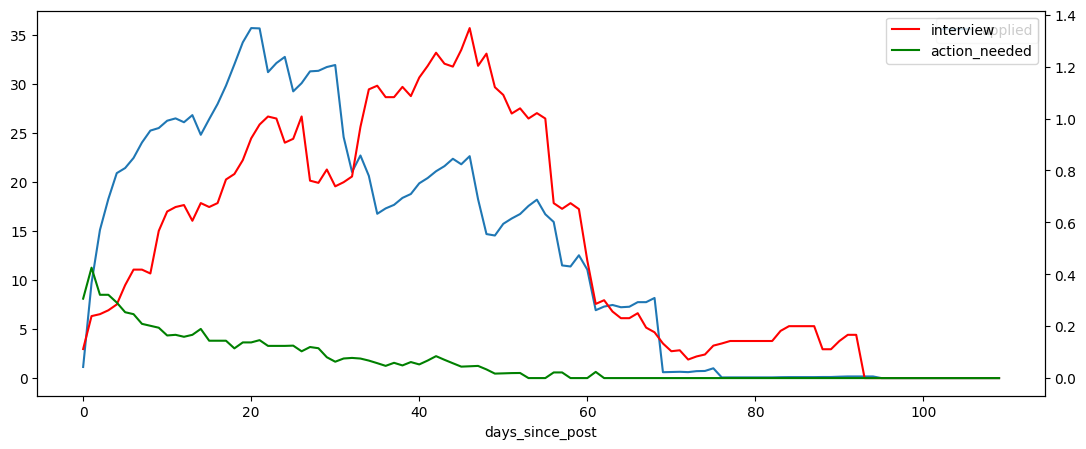

In [185]:
ax = reqs_df.groupby('days_since_post')[['applied']].mean().plot(figsize=(13, 5))
ax2 = ax.twinx()
reqs_df.groupby('days_since_post')[['interview', 'action_needed']].mean().plot(ax=ax2, color=['red', 'green'])

In [88]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

In [96]:
X = reqs_df.drop('action_needed', axis=1).fillna(0)
y = reqs_df['action_needed']
model = DecisionTreeClassifier(max_depth=3).fit(X, y)

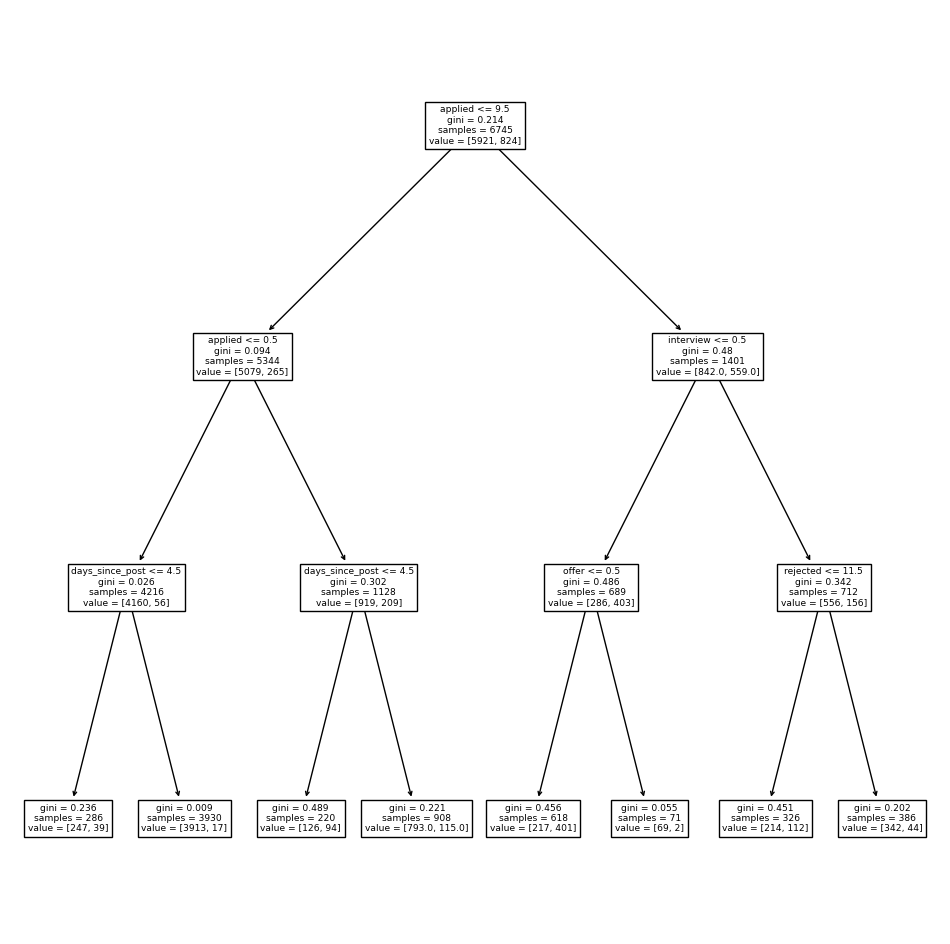

In [97]:
plt.figure(figsize=(12,12))
_ = plot_tree(model, feature_names=X.columns)

In [144]:
reqs_df['priority'] = model.predict_proba(X)[:, 1]
reqs_df['predict'] = model.predict(X)

In [145]:
for f, imp in sorted(zip(X.columns, model.feature_importances_), key=lambda x: -x[1]):
    print(f, imp)

applied 0.6149092577414207
interview 0.17801989092197032
offer 0.09321761540543844
days_since_post 0.07846496626455085
rejected 0.03538826966661985
interview_rejected 0.0


<Axes: xlabel='days_since_post'>

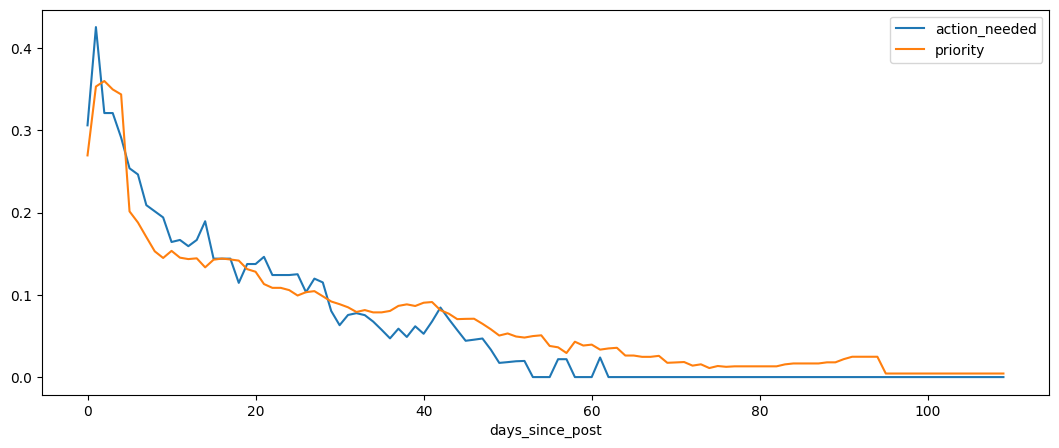

In [146]:
ax = reqs_df.groupby('days_since_post')[['action_needed']].mean().plot(figsize=(13, 5))
reqs_df.groupby('days_since_post')[['priority']].mean().plot(figsize=(13, 5), ax=ax)

In [186]:
X.columns

Index(['days_since_post', 'applied', 'interview', 'interview_rejected',
       'rejected', 'offer'],
      dtype='object')

In [200]:
example = [
    {
        'days_since_post': 0,
        'applied': 0,
        'interview': 0,
        'interview_rejected': 0,
        'rejected': 0,
        'offer': 0
    },
    {
        'days_since_post': 1,
        'applied': 10,
        'interview': 0,
        'interview_rejected': 0,
        'rejected': 0,
        'offer': 0
    },
    {
        'days_since_post': 25,
        'applied': 1,
        'interview': 0,
        'interview_rejected': 0,
        'rejected': 0,
        'offer': 0
    },
    {
        'days_since_post': 25,
        'applied': 10,
        'interview': 0,
        'interview_rejected': 0,
        'rejected': 0,
        'offer': 0
    },
    {
        'days_since_post': 25,
        'applied': 10,
        'interview': 5,
        'interview_rejected': 0,
        'rejected': 0,
        'offer': 0
    },
    {
        'days_since_post': 25,
        'applied': 10,
        'interview': 5,
        'interview_rejected': 0,
        'rejected': 0,
        'offer': 1
    },

]

In [201]:
example_df = pd.DataFrame(example)

In [202]:
example_df['priority'] = model.predict_proba(example_df)[:, 1]

In [203]:
example_df

,days_since_post,applied,interview,interview_rejected,rejected,offer,priority
0,0,0,0,0,0,0,0.136364
1,1,10,0,0,0,0,0.648867
2,25,1,0,0,0,0,0.126652
3,25,10,0,0,0,0,0.648867
4,25,10,5,0,0,0,0.343558
5,25,10,5,0,0,1,0.343558


In [204]:
lr_model = LogisticRegression().fit(X, y)

In [205]:
example_df['priority'] = lr_model.predict_proba(example_df.drop('priority', axis=1))[:, 1]

In [206]:
example_df

,days_since_post,applied,interview,interview_rejected,rejected,offer,priority
0,0,0,0,0,0,0,0.338421
1,1,10,0,0,0,0,0.357721
2,25,1,0,0,0,0,0.204915
3,25,10,0,0,0,0,0.221972
4,25,10,5,0,0,0,0.033719
5,25,10,5,0,0,1,0.001433
